# Classifying the translated z latent embeddings
Due to the architecture of the CI-DI-VAE, we can expect a simple classifier to classify the latent embeddings. 

In [31]:
import scripts.init_gpu as init_gpu
import scripts.init_dataset as init_dataset
from scripts.triplet_functions import n_neurons
import pandas as pd


init_gpu.initialize_gpus()

locations = ['LOC2', 'LOC3']

print("Loading Dataset...")
# load the dataset
df = pd.read_csv(
    f"../dataset/processed/{locations[0]}-{locations[1]}-scaled-balanced.csv")

length = len(df.columns) - 2  # subtract the two label columns

# get train-test set
train_df, test_df, train_web_samples, test_web_samples = init_dataset.get_sample(
    df, locations, range(1500), 1200)

train_df.head()

Num GPUs Available:  0
Loading Dataset...
Training Websites: [1309, 228, 51, 563, 501, 457, 285, 209, 1385, 1116, 178, 1209, 864, 65, 61, 191, 447, 476, 1034, 1232, 54, 1149, 407, 1466, 1330, 1436, 1490, 859, 451, 919, 1206, 569, 13, 326, 1429, 865, 696, 1468, 318, 440, 689, 1492, 189, 778, 198, 735, 704, 1236, 541, 88, 940, 1098, 255, 775, 161, 1130, 600, 1287, 1266, 740, 1182, 393, 142, 93, 1354, 466, 592, 163, 1482, 206, 1456, 1462, 928, 1301, 747, 333, 758, 727, 429, 1372, 546, 1399, 1327, 146, 1247, 1300, 350, 1093, 1495, 334, 946, 777, 552, 1310, 1140, 449, 1402, 664, 114, 469, 1486, 646, 821, 548, 135, 432, 1161, 644, 435, 1342, 1022, 810, 1316, 939, 292, 542, 1493, 505, 1478, 1103, 538, 1197, 877, 1195, 817, 741, 1404, 283, 1043, 1010, 186, 96, 224, 313, 1285, 327, 1487, 1221, 130, 788, 781, 1220, 958, 1083, 514, 1133, 23, 234, 1099, 1419, 1312, 1463, 1498, 601, 890, 323, 929, 6, 539, 1025, 365, 1039, 217, 1280, 611, 1308, 1338, 1415, 1477, 1366, 765, 330, 1104, 1086, 1, 1226, 

/home/e19372/DoH-Synthesis/code/scripts/init_dataset.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.sort_values(by=["Location"], inplace=True)


,Location,Website,0,1,2,3,4,5,6,7,...,118,119,120,121,122,123,124,125,126,127
0,LOC2,0,-0.714089,0.541197,0.391921,-0.400778,-0.266345,-0.522526,0.023889,-0.261817,...,0.125986,0.10277,0.092495,0.043004,0.158904,0.119506,0.099445,0.083843,0.037226,0.152216
1,LOC2,1006,0.093792,-1.273349,-2.142801,1.205098,1.879002,2.139593,1.482513,2.382939,...,0.125986,0.10277,0.092495,0.043004,0.158904,0.119506,0.099445,0.083843,0.037226,0.152216
2,LOC2,1006,1.401091,-1.636258,0.527106,0.354928,-0.017609,-0.049260,-0.177300,-0.412692,...,0.125986,0.10277,0.092495,0.043004,0.158904,0.119506,0.099445,0.083843,0.037226,0.152216
3,LOC2,1006,-0.831599,0.662167,0.527106,0.354928,-0.017609,-0.049260,-0.177300,-0.412692,...,0.125986,0.10277,0.092495,0.043004,0.158904,0.119506,0.099445,0.083843,0.037226,0.152216
4,LOC2,1006,0.093792,-1.152379,-2.007616,0.827245,1.630266,1.666328,1.281324,2.311938,...,0.125986,0.10277,0.092495,0.043004,0.158904,0.119506,0.099445,0.083843,0.037226,0.152216


In [33]:
# models
import tensorflow as tf
from scripts.translate_and_synthsize import SWDLoss
from scripts.train_vae import Sampling, ConvVAE_BatchNorm
latent_dim = 96
swd_loss = SWDLoss(latent_dim)
vae_model = tf.keras.models.load_model(f"../models-{locations[0]}-{locations[1]}/vae/ci_vae/ConvBased/domain_and_class/{locations[0]}-{locations[1]}-e800-mse1-kl0.01-cl1.0-ConvBatchNorm-ldim96-hdim128.keras", custom_objects={'ConvVAE_BatchNorm': ConvVAE_BatchNorm, 'Sampling': Sampling})
translator = tf.keras.models.load_model(f"../models-{locations[0]}-{locations[1]}/latent_translator/translator-kl0.01-e200.keras", custom_objects={'SWDLoss': swd_loss})

/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


# Find the location/domain hyperplane

In [45]:
from scripts.classification import evaluate_classification_model, preprocess_data_for_platform_classification
from sklearn import svm
import numpy as np


def get_z_mean_embeddings(data, vae_model=vae_model):
    embeddings = []
    chunk_size = 200
    for i in range(0, len(data), chunk_size):
        chunk = data[i:i+chunk_size]
        # get the mean instead of z
        transformed_chunk, _, _ = vae_model.encode(chunk)
        embeddings.append(transformed_chunk)

    return np.vstack(embeddings)

X_train, X_test, y_train, y_test, le = preprocess_data_for_platform_classification(train_df, test_df)
X_train_latent = get_z_mean_embeddings(X_train)
X_test_latent = get_z_mean_embeddings(X_test)


model = svm.LinearSVC()
evaluate_classification_model(X_train_latent, y_train, X_test_latent, y_test, model)


weights = model.coef_.flatten()
bias = model.intercept_.flatten()

# Normalize the weight vector
w_norm = weights / np.linalg.norm(weights)

Accuracy: 98.54, F1 Score:  98.54, Precision:  98.58, Recall:  98.54


In [46]:
def jump_to_other_side(z, w, b, alpha=0.1, mirrored=True):
    """
    Jump directly to the other side of the hyperplane.
    
    Parameters:
    - z: The current latent vector (numpy array).
    - w: The normal vector of the hyperplane.
    - b: The bias term of the hyperplane.
    - alpha: Additional step size to cross to the other side.
    
    Returns:
    - z_new: The updated latent vector on the other side.
    """
    # Compute the current value of the decision function
    decision_value = np.dot(w, z) + b
    
    # Compute the displacement to the hyperplane
    delta_z = -decision_value / np.dot(w, w) * w
    
    if mirrored:
        # mirror image of the point
        z_new = z + 2 * delta_z
    else: 
        # Add an additional step to cross the hyperplane
        z_new = z + delta_z + alpha * w

    return z_new

In [32]:
 # data preprocessing for source, real target, and synthetic data
source_location, target_location = locations

target_df = test_df[test_df['Location'] == target_location]
target_df.sort_values(by=['Website'], inplace=True)
target_df.reset_index(drop=True, inplace=True)
target_df.head(20)

source_df = test_df[test_df['Location'] == source_location]
source_df.sort_values(by=['Website'], inplace=True)
source_df.reset_index(drop=True, inplace=True)


translated_z_df = pd.read_csv(f'../synthesized/{target_location}-VAE-Sampling-Z-Translations.csv')
translated_z_df = translated_z_df[translated_z_df['Location'] == target_location]
translated_z_df.sort_values(by=['Website'], inplace=True)
translated_z_df.reset_index(drop=True, inplace=True)




/tmp/ipykernel_828716/955691792.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df.sort_values(by=['Website'], inplace=True)
/tmp/ipykernel_828716/955691792.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source_df.sort_values(by=['Website'], inplace=True)


In [67]:
from scripts.translate_and_synthsize import get_z_embeddings, get_z_translations

source_z = get_z_mean_embeddings(source_df.iloc[:, 2:], vae_model)
target_z = get_z_mean_embeddings(target_df.iloc[:, 2:], vae_model)
translated_z = translated_z_df.iloc[:, 2:]
mirrored_z = np.zeros(source_z.shape)
for i in range(source_z.shape[0]):
    mirrored_z[i] = jump_to_other_side(source_z[i], w_norm, bias, mirrored=True)

# Simple NN Classifier

In [60]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

def create_simple_dense_classifier(input_dim, num_classes, hidden_units=64, dropout_rate=0.1):
    """
    Creates a simple dense neural network classifier.

    Parameters:
    - input_dim: int, the number of features in the input data.
    - num_classes: int, the number of output classes.
    - hidden_units: int, the number of neurons in the hidden layer.
    - dropout_rate: float, the dropout rate for regularization.

    Returns:
    - model: A compiled Keras model.
    """
    model = Sequential([
        Dense(hidden_units, activation='relu', input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(hidden_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',  # Suitable for integer-encoded labels
        metrics=['accuracy']
    )

    return model

def create_linear_classifier(input_dim, num_classes, hidden_units=64, dropout_rate=0.1):
    model = Sequential([
        Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',  # Suitable for integer-encoded labels
        metrics=['accuracy']
    )

    return model

# Verification: Can it even classifiy the source samples, trained on source data

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
random_state = 42

le = LabelEncoder()
source_train, source_test = train_test_split(source_df, test_size=0.7, random_state=random_state, stratify=source_df['Website'])

X_train = get_z_embeddings(source_train.iloc[:, 2:], vae_model)
y_train = le.fit_transform(source_train.Website)
X_test = get_z_embeddings(source_test.iloc[:, 2:], vae_model)
y_test = le.transform(source_test.Website)


model = create_simple_dense_classifier(latent_dim, len(test_web_samples))
model.fit(X_train, y_train, batch_size = 32, epochs=30, shuffle=True)

Epoch 1/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0738 - loss: 5.3592
Epoch 2/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7074 - loss: 2.6396
Epoch 3/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8997 - loss: 1.3121
Epoch 4/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9435 - loss: 0.7834
Epoch 5/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9684 - loss: 0.5142
Epoch 6/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9760 - loss: 0.3769
Epoch 7/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9827 - loss: 0.2920
Epoch 8/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9846 - loss: 0.2355
Epoch 9/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9881 - loss: 0.1887
Epoch 10/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.1589
Epoch 11/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.1346
Epoch 12/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

650/650 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
Accuracy: 0.9326
F1 Score (weighted): 0.9336


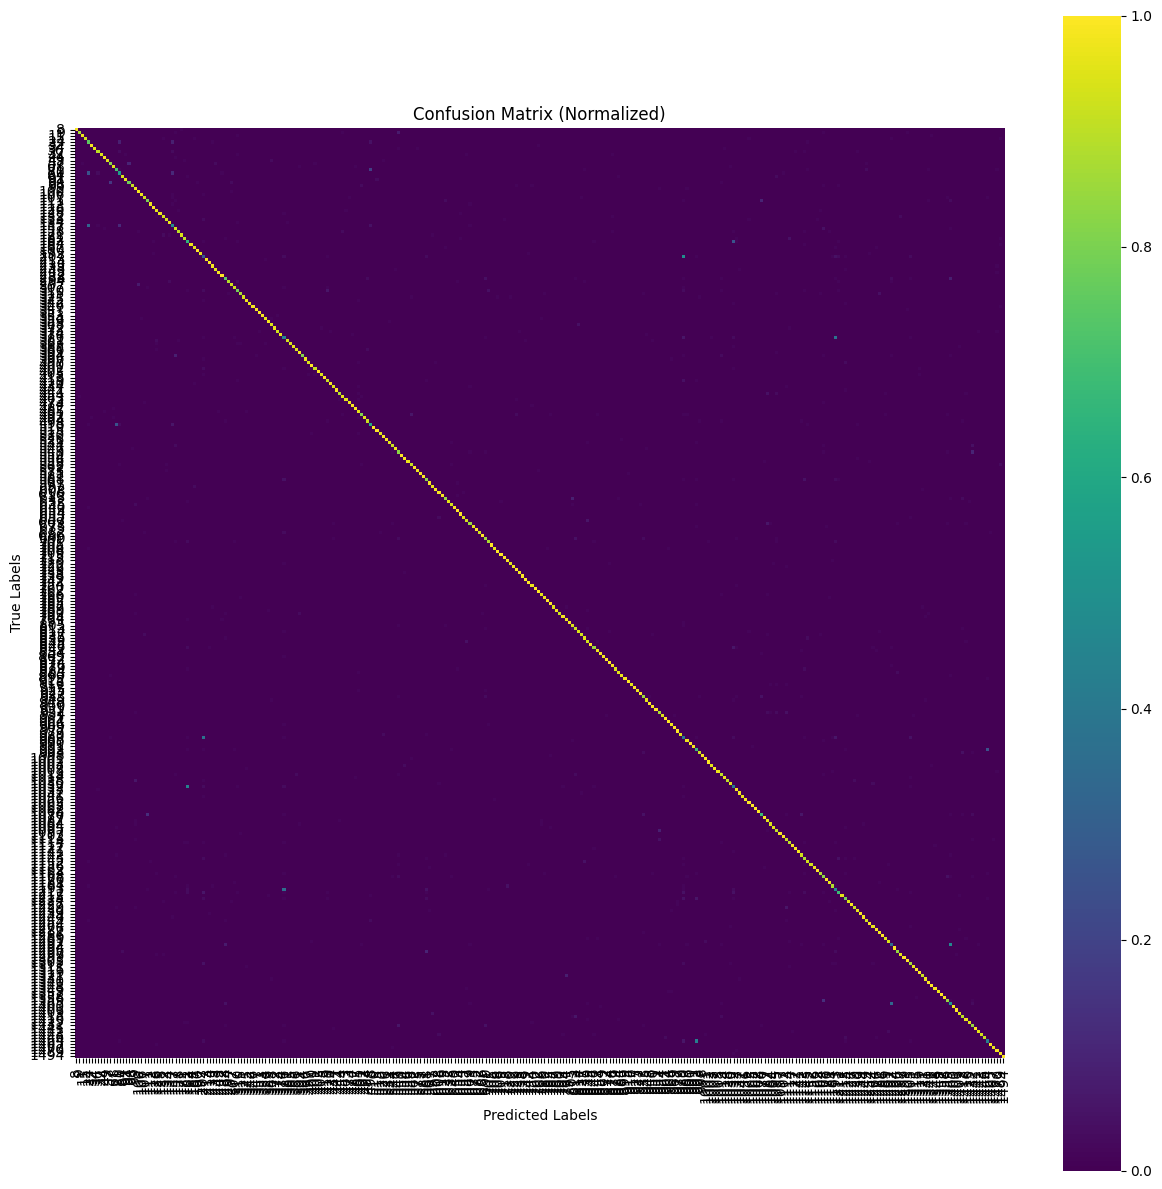

In [44]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import scripts.classification as classification

# Convert logits to class labels
y_pred_logits = model.predict(X_test)
y_pred = np.argmax(y_pred_logits, axis=1)  # Get class indices with maximum logits

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average for imbalanced data
print(f"F1 Score (weighted): {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
classification.show_confusion_matrix_heatmap(cm, le, 'cm', True)

### Can it classify the target test samples

929/929 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
Accuracy: 0.4728


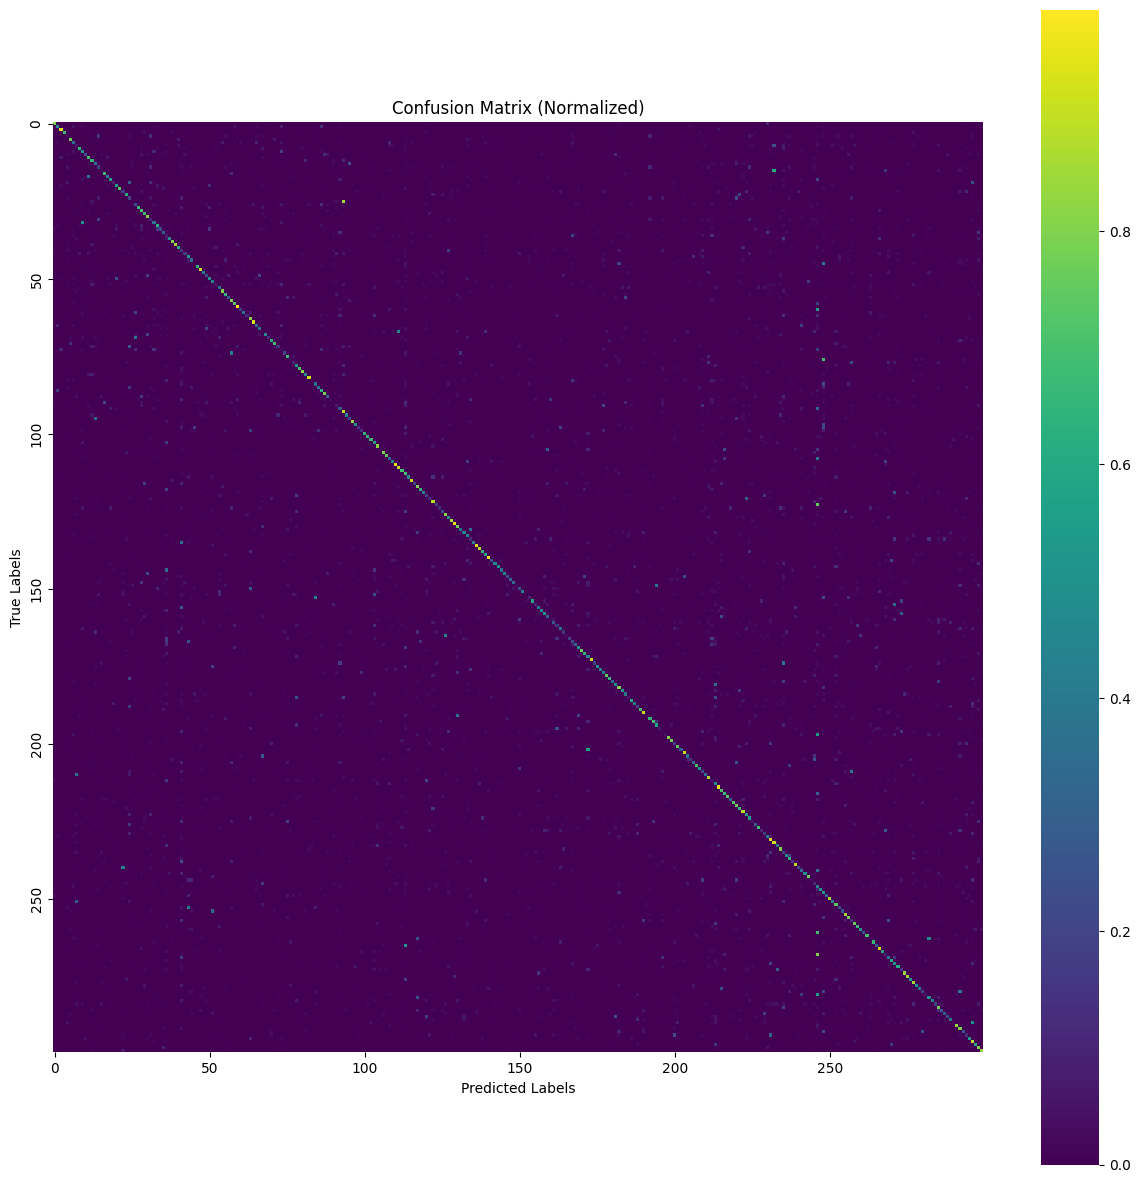

In [22]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import scripts.classification as classification
# Convert logits to class labels
y_pred_logits = model.predict(get_z_embeddings(target_df.iloc[:, 2:], vae_model))
y_pred = np.argmax(y_pred_logits, axis=1)  # Get class indices with maximum logits
y_test = le.transform(target_df.Website)
# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred)
classification.show_confusion_matrix_heatmap(cm, le, 'cm', False)

# Trained on source location z and mirrored, test on real

In [70]:
from sklearn.preprocessing import LabelEncoder
import scripts.classification as classification 
le = LabelEncoder()

X_train = np.concat([source_z, mirrored_z])
y_train = le.fit_transform(np.concat([source_df.Website, source_df.Website]))
X_test = target_z
y_test = le.transform(target_df.Website)

model = create_simple_dense_classifier(latent_dim, len(test_web_samples))
model.fit(X_train, y_train, batch_size = 32, epochs=20, shuffle=True)

Epoch 1/20


/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1857/1857 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5010 - loss: 2.5641
Epoch 2/20
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9135 - loss: 0.2833
Epoch 3/20
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9363 - loss: 0.1906
Epoch 4/20
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9494 - loss: 0.1495
Epoch 5/20
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9511 - loss: 0.1389
Epoch 6/20
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9547 - loss: 0.1248
Epoch 7/20
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9589 - loss: 0.1133
Epoch 8/20
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9593 - loss: 0.1100
Epoch 9/20
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9603 - loss: 0.1028
Epoch 10/20
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9616 - loss: 0.1014
Epoch 11/20
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9604 - loss: 0.1023
Epoch 12/20
1857/1857 ━━━━━━━━━━━━━━━━━━━

929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step
Accuracy: 0.5988


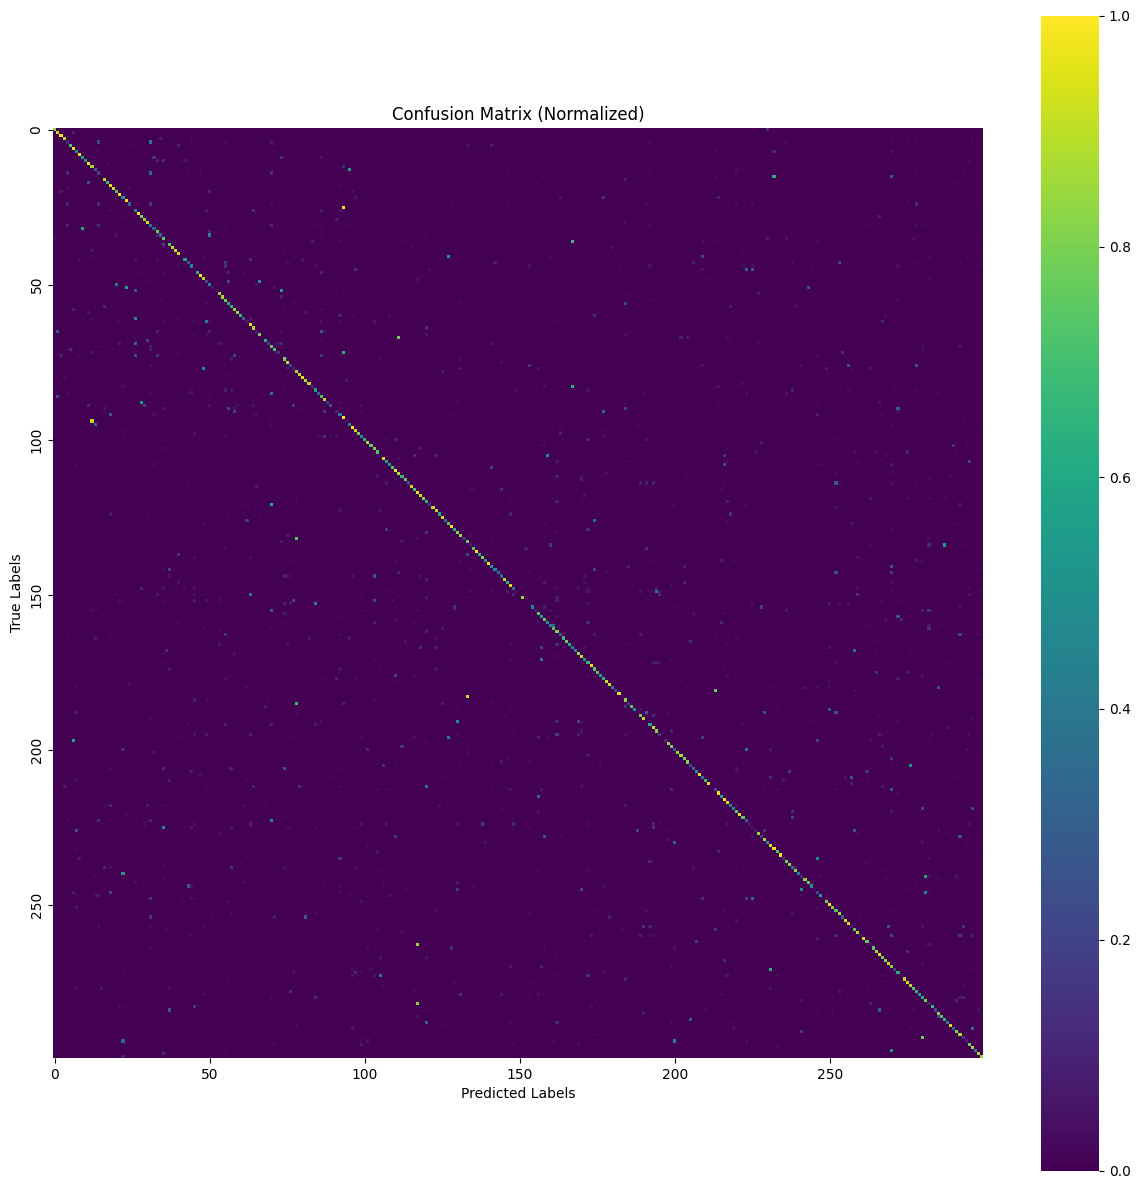

In [71]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import scripts.classification as classification
# Convert logits to class labels
y_pred_logits = model.predict(X_test)
y_pred = np.argmax(y_pred_logits, axis=1)  # Get class indices with maximum logits
y_test = le.transform(target_df.Website)
# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred)
classification.show_confusion_matrix_heatmap(cm, le, 'cm', False)

## Trained on source location z embeddings

In [23]:
from sklearn.preprocessing import LabelEncoder
import scripts.classification as classification 
le = LabelEncoder()

X_train = source_z
y_train = le.fit_transform(source_df.Website)
X_test = target_z
y_test = le.transform(target_df.Website)

model = create_simple_dense_classifier(latent_dim, len(test_web_samples))
model.fit(X_train, y_train, batch_size = 32, epochs=20, shuffle=True)

Epoch 1/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - accuracy: 0.3606 - loss: 3.9637
Epoch 2/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - accuracy: 0.9369 - loss: 0.6509
Epoch 3/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - accuracy: 0.9631 - loss: 0.3096
Epoch 4/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - accuracy: 0.9727 - loss: 0.2041
Epoch 5/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - accuracy: 0.9779 - loss: 0.1445
Epoch 6/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - accuracy: 0.9800 - loss: 0.1156
Epoch 7/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - accuracy: 0.9812 - loss: 0.0941
Epoch 8/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - accuracy: 0.9847 - loss: 0.0799
Epoch 9/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - accuracy: 0.9869 - loss: 0.0663
Epoch 10/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - accuracy: 0.9877 - loss: 0.0579
Epoch 11/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.9886 - loss: 0.0528
Epoch 12/20
929/929 ━━━━━━━━━━

  1/929 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step

929/929 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
Accuracy: 0.5360
F1 Score (weighted): 0.5132


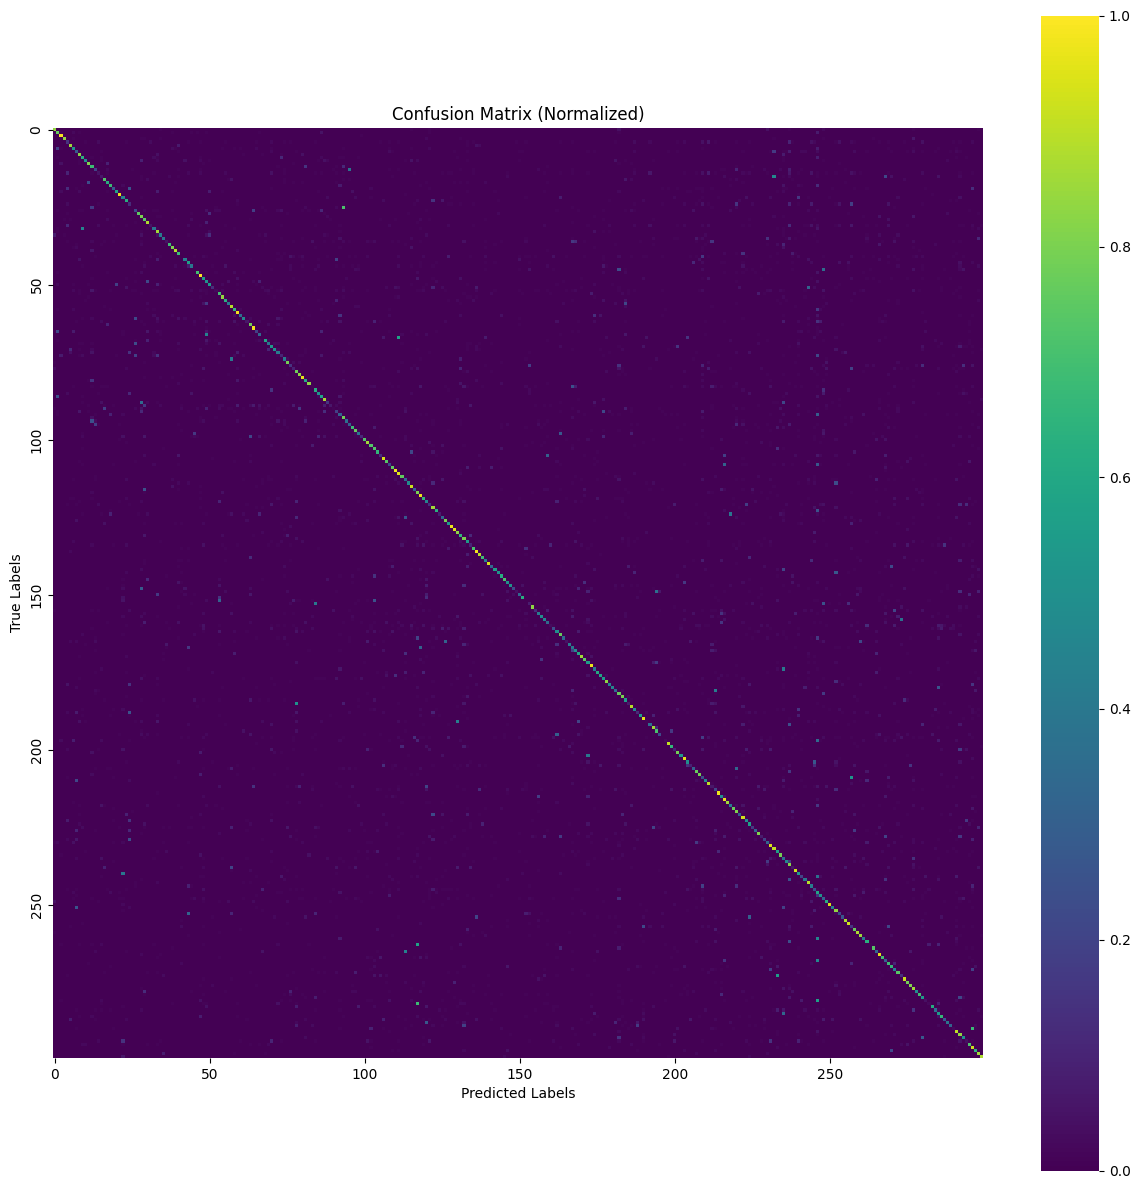

In [25]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Convert logits to class labels
y_pred_logits = model.predict(X_test)
y_pred = np.argmax(y_pred_logits, axis=1)  # Get class indices with maximum logits

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average for imbalanced data
print(f"F1 Score (weighted): {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
classification.show_confusion_matrix_heatmap(cm, le, 'cm', False)

## Trained on translated z embeddings



In [35]:
from sklearn.preprocessing import LabelEncoder
import scripts.classification as classification 
le = LabelEncoder()

X_train = source_df.iloc[:, 2:]
y_train = le.fit_transform(source_df.Website)
X_test = target_z
y_test = le.transform(target_df.Website)

# model = create_simple_dense_classifier(latent_dim, len(test_web_samples))
model.fit(X_train, y_train, batch_size = 128, epochs=10, shuffle=True)

InvalidArgumentError: Exception originated from

  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
    self._run_once()
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
    handle._run()
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/asyncio/events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    await self.process_one()
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    await dispatch(*args)
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    await result
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
    await super().execute_request(stream, ident, parent)
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    reply_content = await reply_content
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
    res = shell.run_cell(
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
    result = self._run_cell(
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
    result = runner(coro)
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_230991/2960372031.py", line 11, in <module>
    model.fit(X_train, y_train, batch_size = 128, epochs=10, shuffle=True)
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit
    logs = self.train_function(iterator)
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function
    opt_outputs = multi_step_on_iterator(iterator)
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 833, in __call__
    result = self._call(*args, **kwds)
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 878, in _call
    results = tracing_compilation.call_function(
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/tensorflow/python/eager/polymorphic_function/tracing_compilation.py", line 139, in call_function
    return function._call_flat(  # pylint: disable=protected-access
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/tensorflow/python/eager/polymorphic_function/concrete_function.py", line 1322, in _call_flat
    return self._inference_function.call_preflattened(args)
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py", line 216, in call_preflattened
    flat_outputs = self.call_flat(*args)
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py", line 251, in call_flat
    outputs = self._bound_context.call_function(
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/tensorflow/python/eager/context.py", line 1683, in call_function
    outputs = execute.execute(
  File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,

{{function_node __inference_multi_step_on_iterator_2027963}} Matrix size-incompatible: In[0]: [128,128], In[1]: [96,128]

Stack trace for op definition: 
File "<frozen runpy>", line 198, in _run_module_as_main
File "<frozen runpy>", line 88, in _run_code
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/asyncio/events.py", line 84, in _run
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
File "/tmp/ipykernel_230991/2960372031.py", line 11, in <module>
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 57, in train_step
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/layers/layer.py", line 908, in __call__
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/models/sequential.py", line 213, in call
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/models/functional.py", line 182, in call
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/models/functional.py", line 637, in call
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/layers/layer.py", line 908, in __call__
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py", line 144, in call
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 3815, in matmul
File "/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 501, in matmul

	 [[{{node sequential_12_1/dense_33_1/MatMul}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_2027906[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]]
	Encountered when executing an operation using EagerExecutor. This error cancels all future operations and poisons their output tensors. [Op:RangeDataset] name: 

In [33]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Convert logits to class labels
y_pred_logits = model.predict(X_test)
y_pred = np.argmax(y_pred_logits, axis=1)  # Get class indices with maximum logits

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average for imbalanced data
print(f"F1 Score (weighted): {f1:.4f}")

  1/929 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step

929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.2514
F1 Score (weighted): 0.2255


# Both translated and source z embeddings for training

In [23]:
from sklearn.preprocessing import LabelEncoder
import scripts.classification as classification 
le = LabelEncoder()


X_train = np.concatenate([source_z, get_z_translations(source_z, translator)])

y_train = le.fit_transform(source_df.Website)
y_train = np.concatenate([y_train, le.transform(source_df.Website)])

X_test = target_z
y_test = le.transform(target_df.Website)

model = create_simple_dense_classifier(latent_dim, len(test_web_samples))
model.fit(X_train, y_train, batch_size = 32, epochs=40, shuffle=True)

Epoch 1/40


/home/e19372/anaconda3/envs/doh_synth_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1857/1857 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1131 - loss: 4.5472
Epoch 2/40
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4210 - loss: 2.1812
Epoch 3/40
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4987 - loss: 1.8455
Epoch 4/40
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5285 - loss: 1.7054
Epoch 5/40
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5466 - loss: 1.6341
Epoch 6/40
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5520 - loss: 1.5916
Epoch 7/40
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5607 - loss: 1.5679
Epoch 8/40
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5715 - loss: 1.5280
Epoch 9/40
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5717 - loss: 1.5290
Epoch 10/40
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5772 - loss: 1.4975
Epoch 11/40
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5829 - loss: 1.4874
Epoch 12/40
1857/1857 ━━━━━━━━━━━━━━━━━━━

In [25]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Convert logits to class labels
y_pred_logits = model.predict(X_test)
y_pred = np.argmax(y_pred_logits, axis=1)  # Get class indices with maximum logits

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

f1 = f1_score(y_test, y_pred, average='weighted')  # Use weighted average for imbalanced data
print(f"F1 Score (weighted): {f1:.4f}")

929/929 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step
Accuracy: 0.5856
F1 Score (weighted): 0.5610
